In [1]:
import pandas as pd 
import torch
import rasterio
import numpy
import sklearn

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

# Load the uploaded CSV file
file_path = './treecrown_mergeAGB_6b_modelling.csv'
df = pd.read_csv(file_path)
'''
# Copy data to avoid modifying the original dataframe
df_cleaned = df.copy()

def remove_outliers_isolation_forest(data):
    # Apply Isolation Forest
    iso_forest = IsolationForest(contamination=0.4)  # Adjust contamination based on your dataset
    outliers = iso_forest.fit_predict(data)
    # Remove rows classified as outliers (-1)
    return data[outliers == 1]

# Apply Isolation Forest outlier removal
df_cleaned = df.copy()
df_cleaned = remove_outliers_isolation_forest(df_cleaned.drop(columns=['AGB_edit']))
df_cleaned['AGB_edit'] = df['AGB_edit'][df_cleaned.index]  # Retain the target variable
df_cleaned.dropna(inplace=True)

# Separate features (X) and target (y) from the cleaned data
X_cleaned = df_cleaned.drop(columns=['AGB_edit'])
y_cleaned = df_cleaned['AGB_edit']

# Check the shape after outlier removal to confirm data was reduced
print(f"Data shape after outlier removal: {df_cleaned.shape}")

# Proceed with the train-test split on the cleaned data
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)
'''


Data shape after outlier removal: (74, 745)


In [5]:
# Separate features (X) and target (y) from the cleaned data
X_cleaned = df.drop(columns=['AGB_edit'])
y_cleaned = df['AGB_edit']

# Proceed with the train-test split on the cleaned data
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.3, random_state=42)

print(X_train.shape)

# Now continue with the RFE feature selection, GridSearchCV, and model evaluation steps as before.

(86, 744)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features (X) and target (y)
X = df.drop(columns=['AGB'])
y = df['AGB']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the training and testing sets to confirm successful split
X_train.shape, X_test.shape, y_train.shape, y_test.shape


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

# Initialize a Random Forest Regressor for feature selection
rfe_selector = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=50)
rfe_selector.fit(X_train, y_train)

# Get the ranking of the features
selected_features = X_train.columns[rfe_selector.support_]
selected_features


Index(['_b1_median', '_b1_range', '_b2_sum', '_b2_max', '_b3_max', '_b4_range',
       '_b5_max', '_b7_minori', '_b8_stdev', '_b10_max', '_b10_range',
       '_b11_range', '_b12_range', '_b14_range', '_b17_media', '_b18_range',
       '_b20_sum', '_b22_stdev', '_b23_stdev', '_b23_max', '_b23_range',
       '_b24_media', '_b24_stdev', '_b24_range', '_b26_media', '_b27_media',
       '_b27_max', '_b28_media', '_b33_media', '_b34_mea_1', '_b35_range',
       '_b35_varie', '_b38_media', '_b39_major', '_b40_sum', '_b41_sum',
       '_b42_mea_1', '_b42_max', '_b42_major', '_b42_varia', '_b43_stdev',
       '_b45_mea_1', '_b46_minor', '_b60_max', '_b60_range', '_b61_max',
       '_b61_range', '_b61_major', '_b62_media', '_b62_major'],
      dtype='object')

In [15]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import joblib

# Filter the training and testing sets to include only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Define parameter grids for each model
param_grids = {
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'random_state': [42]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'random_state': [42]
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesRegressor(),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'random_state': [42]
        }
    },
    'MLP': {
        'model': MLPRegressor(),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd'],
            'learning_rate': ['constant', 'adaptive'],
            'max_iter': [200, 500],
            'random_state': [42]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['rbf'],
            'C': [0.1, 1, 10, 100],
            'epsilon': [0.01, 0.1, 0.2]
        }
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_child_weight': [1, 3, 5],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'random_state': [42]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMRegressor(),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'num_leaves': [31, 63, 127],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'random_state': [42]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1, 10],
            'max_iter': [1000, 5000],
            'random_state': [42]
        }
    }
}

# Dictionary to store the best results
results = {}

# Perform GridSearchCV for each model
for model_name, config in param_grids.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(estimator=config['model'], 
                               param_grid=config['params'], 
                               cv=3, n_jobs=-1, verbose=1, scoring='r2')
    grid_search.fit(X_train_selected, y_train)
    
    # Store best parameters, score, and estimator
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_estimator': grid_search.best_estimator_
    }
    
    # Save the best model using joblib
    model_filename = f"{model_name}_best_model.joblib"
    joblib.dump(grid_search.best_estimator_, model_filename)
    print(f"Saved {model_name} best model to {model_filename}")

# Dictionary to store evaluation metrics on the train and test sets
train_metrics = []
test_metrics = []

# Evaluate each best model on the train and test set and collect metrics for CSV export
for model_name, result in results.items():
    best_estimator = result['best_estimator']
    
    # Make predictions on the training set
    y_train_pred = best_estimator.predict(X_train_selected)
    
    # Make predictions on the test set
    y_test_pred = best_estimator.predict(X_test_selected)
    
    # Calculate evaluation metrics for training set
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    
    # Calculate evaluation metrics for test set
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    
    # Store the results in a dictionary for CSV export
    train_metrics.append({
        'Model': model_name,
        'R^2 Score (Train)': r2_train,
        'Mean Absolute Error (MAE) Train': mae_train,
        'Mean Squared Error (MSE) Train': mse_train,
        'Root Mean Squared Error (RMSE) Train': rmse_train
    })
    
    test_metrics.append({
        'Model': model_name,
        'R^2 Score (Test)': r2_test,
        'Mean Absolute Error (MAE) Test': mae_test,
        'Mean Squared Error (MSE) Test': mse_test,
        'Root Mean Squared Error (RMSE) Test': rmse_test
    })

# Convert the lists of dictionaries to DataFrames
df_train_results = pd.DataFrame(train_metrics)
df_test_results = pd.DataFrame(test_metrics)

# Save the results to CSV files
train_csv_filename = "train_model_evaluation_results.csv"
test_csv_filename = "test_model_evaluation_results.csv"
df_train_results.to_csv(train_csv_filename, index=False)
df_test_results.to_csv(test_csv_filename, index=False)

print(f"\nSaved training metrics to {train_csv_filename}")
print(f"Saved test metrics to {test_csv_filename}")

# Display the DataFrames
print("\nTraining Model Evaluation Results:")
print(df_train_results)
print("\nTest Model Evaluation Results:")
print(df_test_results)


Training RandomForest...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Saved RandomForest best model to RandomForest_best_model.joblib
Training GradientBoosting...
Fitting 3 folds for each of 243 candidates, totalling 729 fits


c:\Users\sanji\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Saved GradientBoosting best model to GradientBoosting_best_model.joblib
Training ExtraTrees...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Saved ExtraTrees best model to ExtraTrees_best_model.joblib
Training MLP...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Saved MLP best model to MLP_best_model.joblib
Training SVR...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Saved SVR best model to SVR_best_model.joblib
Training XGBoost...
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Saved XGBoost best model to XGBoost_best_model.joblib
Training LightGBM...
Fitting 3 folds for each of 324 candidates, totalling 972 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1443
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 50
[LightGBM] [Info] Start trai

c:\Users\sanji\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.609e+02, tolerance: 1.909e+01
  model = cd_fast.enet_coordinate_descent(


RandomForest - Test R^2 Score: 0.3064
RandomForest - Test Mean Absolute Error: 29.7655
RandomForest - Test Mean Squared Error: 1737.1999
RandomForest - Test Root Mean Squared Error: 41.6797

GradientBoosting - Test R^2 Score: 0.1134
GradientBoosting - Test Mean Absolute Error: 32.5142
GradientBoosting - Test Mean Squared Error: 2220.5006
GradientBoosting - Test Root Mean Squared Error: 47.1222

MLP - Test R^2 Score: -0.0003
MLP - Test Mean Absolute Error: 42.1951
MLP - Test Mean Squared Error: 2505.3951
MLP - Test Root Mean Squared Error: 50.0539

SVR - Test R^2 Score: 0.1592
SVR - Test Mean Absolute Error: 36.5645
SVR - Test Mean Squared Error: 2105.9684
SVR - Test Root Mean Squared Error: 45.8908



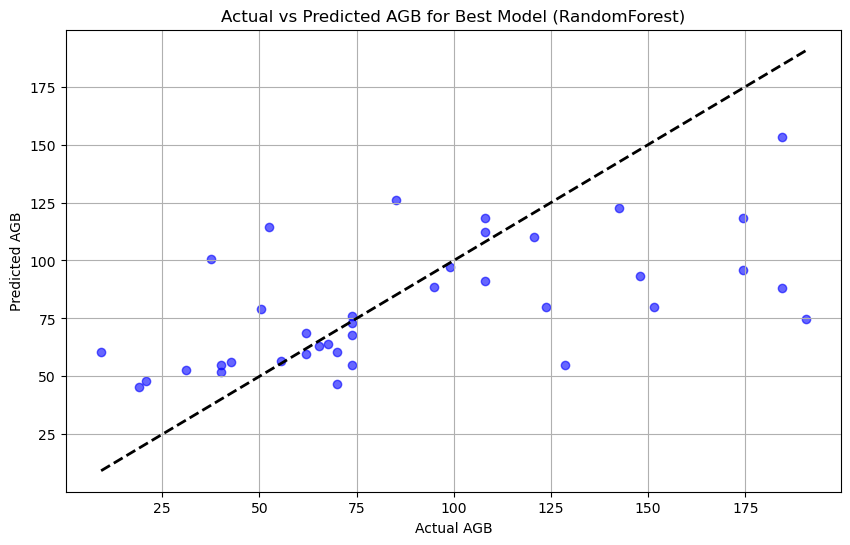

In [12]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Dictionary to store the test results
test_results = {}

# Evaluate each model on the test set
for model_name, result in results.items():
    best_model = result['best_params']
    # Set up the model with the best parameters from GridSearchCV
    best_estimator = param_grids[model_name]['model'].set_params(**best_model)
    best_estimator.fit(X_train_selected, y_train)  # Re-train on the full training set with the best parameters
    
    # Make predictions on the test set
    y_pred = best_estimator.predict(X_test_selected)
    
    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Store the results
    test_results[model_name] = {
        'r2_score': r2,
        'mean_absolute_error': mae,
        'mean_squared_error': mse,
        'root_mean_squared_error': rmse,
        'predictions': y_pred
    }

# Print out the test results for each model
for model_name, result in test_results.items():
    print(f"{model_name} - Test R^2 Score: {result['r2_score']:.4f}")
    print(f"{model_name} - Test Mean Absolute Error: {result['mean_absolute_error']:.4f}")
    print(f"{model_name} - Test Mean Squared Error: {result['mean_squared_error']:.4f}")
    print(f"{model_name} - Test Root Mean Squared Error: {result['root_mean_squared_error']:.4f}\n")

# Identify the model with the highest R^2 score on the test set
best_model_name = max(test_results, key=lambda x: test_results[x]['r2_score'])
best_predictions = test_results[best_model_name]['predictions']

# Plot actual vs. predicted values for the best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_predictions, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual AGB')
plt.ylabel('Predicted AGB')
plt.title(f'Actual vs Predicted AGB for Best Model ({best_model_name})')
plt.grid(True)
plt.show()

In [9]:
import geopandas as gpd
from tqdm import tqdm
from glob import glob
import os
import joblib
from joblib import Parallel, delayed
import numpy as np

output_dir = "./Predicted_TreeAGB/"
os.makedirs(output_dir, exist_ok=True)

selected_features2 = ['_b1_median', '_b1_range', '_b2_sum', '_b2_max', '_b3_max', '_b4_range',
       '_b5_max', '_b7_minori', '_b8_stdev', '_b10_max', '_b10_range',
       '_b11_range', '_b12_range', '_b14_range', '_b17_media', '_b18_range',
       '_b20_sum', '_b22_stdev', '_b23_stdev', '_b23_max', '_b23_range',
       '_b24_media', '_b24_stdev', '_b24_range', '_b26_media', '_b27_media',
       '_b27_max', '_b28_media', '_b33_media', '_b34_mea_1', '_b35_range',
       '_b35_varie', '_b38_media', '_b39_major', '_b40_sum', '_b41_sum',
       '_b42_mea_1', '_b42_max', '_b42_major', '_b42_varia', '_b43_stdev',
       '_b45_mea_1', '_b46_minor', '_b60_max', '_b60_range', '_b61_max',
       '_b61_range', '_b61_major', '_b62_media', '_b62_major']

best_model = joblib.load("./Final_Model/RandomForest_best_model.joblib")

list_data = glob(os.path.join("./treecrown_split/", "*.shp"))

def predict_chunk(model, X_chunk):
    return model.predict(X_chunk)

def process_file(filepath):
    gdf = gpd.read_file(filepath, engine = 'pyogrio', use_arrow=True)
    #X2 = gdf[selected_features2]
    X2 = gdf[selected_features2].fillna(0)
    filename = os.path.basename(filepath)
    print("start processing ", filename)
    #gdf['AGB_prediction'] = best_model.predict(X2)
    gdf['AGB_pred'] = best_model.predict(X2)

    output_path = os.path.join(output_dir, f"Predicted_RF_TreeAGB_{filename}")
    gdf.to_file(output_path)
    print(f"Finished processing {filename}")

n_jobs = -1  # Use all available CPUs
Parallel(n_jobs=n_jobs, backend="loky")(delayed(process_file)(filepath) for filepath in tqdm(list_data))

100%|██████████| 20/20 [00:00<?, ?it/s]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]